In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("high_diamond_ranked_10min.csv")
data.head()

In [ ]:
data.info()

In [ ]:
data.nunique()


In [ ]:
data.corr()["blueWins"].sort_values(ascending=False)

In [ ]:
fig , ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(data.corr(), annot=True ,ax=ax, cmap="YlGnBu",linewidths = .5)
ax.set_title("Correlation Between variables", fontsize=36)
plt.show()

In [ ]:
data = pd.read_csv("high_diamond_ranked_10min.csv")
data.columns

In [ ]:
low_values = ['blueWardsPlaced','blueWardsDestroyed','blueKills',
              'blueDeaths','blueAssists','blueAvgLevel','blueTotalMinionsKilled',
              'blueTotalJungleMinionsKilled','redWardsPlaced','redWardsDestroyed',
              'redAssists','redAvgLevel','redTotalMinionsKilled',
              'redTotalJungleMinionsKilled']

In [ ]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True}) # using https://scikit-learn.org/0.24/auto_examples/model_selection/plot_grid_search_stats.html
def search_lineplot(model, filename):
    results_df = pd.DataFrame(model.cv_results_)
    results_df = results_df.sort_values(by=['rank_test_score'])
    results_df = (
        results_df
        .set_index(results_df["params"].apply(
            lambda x: "_".join(str(val) for val in x.values()))
        )
        .rename_axis('parameters')
    )
    model_scores = results_df.filter(regex=r'split\d*_test_score')

    fig, ax = plt.subplots()
    sns.lineplot(
        data=model_scores.transpose().iloc[:5],
        dashes = True,marker='o', ax=ax
    )
    ax.set_xlabel("CV test fold", size=12, labelpad=10)
    ax.set_ylabel("Model AUC", size=12)
    ax.tick_params(axis="x",bottom=True, labelbottom=True,rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig('{}.png'.format(filename,dpi = 300))

    print(f"Correlation of models:\n {model_scores.transpose().corr()}")

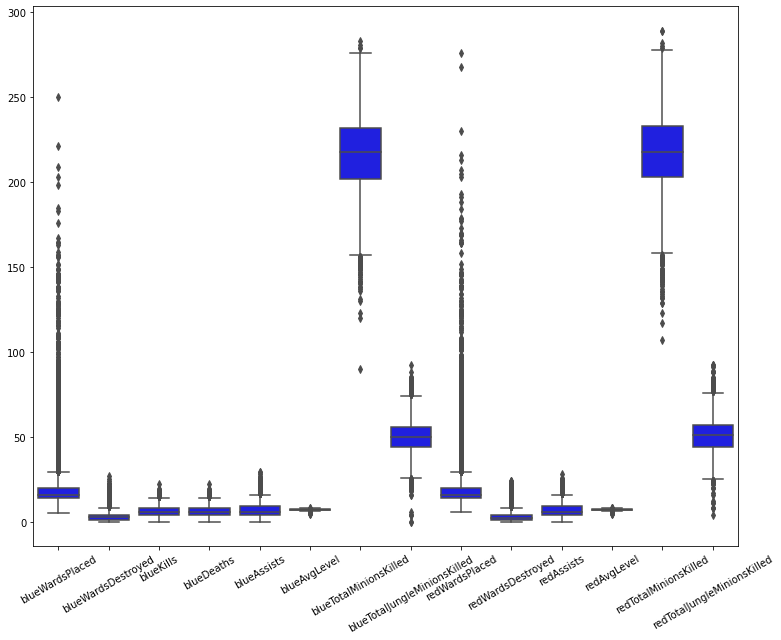

In [42]:
cleandata = data.drop(['redFirstBlood','redDeaths','redKills','redExperienceDiff','redGoldDiff', 'gameId','redCSPerMin', 'redGoldPerMin','blueCSPerMin', 'blueGoldPerMin'], axis = 1)
cleandata.describe()
plt.figure(figsize = (11,9))
g = sns.boxplot(data = cleandata[low_values], color = "blue")
plt.xticks(rotation = 30)
plt.show()
# print(cleandata.describe())


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = cleandata.drop('blueWins', axis=1)
y = cleandata['blueWins']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
import matplotlib.pyplot as plt
def single_influence(model,attribute_ref, attributename, filename):
    plt.plot(grid_parameters[attribute_ref], model.cv_results_["mean_test_score"])
    plt.title("The influence of {} on accuracy".format(attributename))
    plt.xlabel(attributename)
    plt.xticks(grid_parameters[attribute_ref])
    plt.ylabel("Accuracy")
    plt.savefig('{}.png'.format(filename,dpi = 300))

In [ ]:
best_clfs = []
best_models = []

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
pipe = make_pipeline(DecisionTreeClassifier())
# print(pipe.get_params().keys())
grid_parameters = {
    "decisiontreeclassifier__criterion" : ['gini', 'entropy'],
    "decisiontreeclassifier__max_depth" : [2,4,6],
    "decisiontreeclassifier__min_samples_split" : [2,4,6]
}


clf_decision_tree = GridSearchCV(pipe, grid_parameters)
best_decision_tree = clf_decision_tree.fit(X_train, y_train)

# print('Best Criterion:', clf_decision_tree.best_estimator_.get_params()['decisiontreeclassifier__criterion'])
# print('Best max_depth:', clf_decision_tree.best_estimator_.get_params()['decisiontreeclassifier__max_depth'])
# print('Best samples_split:', clf_decision_tree.best_estimator_.get_params()['decisiontreeclassifier__min_samples_split'])
# print()
# print("The mean accuracy of the model is:",best_decision_tree.score(X_test,y_test))

best_clfs.append(clf_decision_tree)
best_models.append(best_decision_tree)
# search_lineplot(best_decision_tree,"decision_tree_all")
# single_influence(best_decision_tree, grid_parameters["decisiontreeclassifier__max_depth"], "max depth", "max_depth_decisiontree")

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
pipe = make_pipeline(SelectKBest(),DecisionTreeClassifier())
print(pipe.get_params().keys())
grid_parameters = [{
    "selectkbest__k" : [2,3,4,6,8,10,15,20],
    "decisiontreeclassifier" : [DecisionTreeClassifier()],
    "decisiontreeclassifier__criterion" : ['gini', 'entropy'],
    "decisiontreeclassifier__max_depth" : [2,4,6],
    "decisiontreeclassifier__min_samples_split" : [2,4,6]
}]


clf_decision_tree_with_selectKBest = GridSearchCV(pipe, grid_parameters,n_jobs=-1)
best_decision_tree_with_selectKBest = clf_decision_tree_with_selectKBest.fit(X_train, y_train)
# print('Best Criterion:', clf_decision_tree_with_selectKBest.best_estimator_.get_params()['decisiontreeclassifier__criterion'])
# print('Best max_depth:', clf_decision_tree_with_selectKBest.best_estimator_.get_params()['decisiontreeclassifier__max_depth'])
# print('Best samples_split:', clf_decision_tree_with_selectKBest.best_estimator_.get_params()['decisiontreeclassifier__min_samples_split'])
# print('Best k in selectKBest:',clf_decision_tree_with_selectKBest.best_estimator_.get_params()['selectkbest__k'])
# print()
# print("The mean accuracy of the model is:",best_decision_tree_with_selectKBest.score(X_test,y_test))

best_clfs.append(clf_decision_tree_with_selectKBest)
best_models.append(best_decision_tree_with_selectKBest)
# search_lineplot(best_decision_tree_with_selectKBest,"SelectKBestonly")
# # single_influence(best_decision_tree_with_selectKBest, "selectkbest__k", "K value", "selectKBest_kval")

In [ ]:
from sklearn.neural_network import MLPClassifier
pipe = make_pipeline(MLPClassifier(max_iter=700,random_state=42))
# print(pipe.get_params().keys())
grid_parameters = {
    'mlpclassifier__hidden_layer_sizes': [(70,),(100,)],
    'mlpclassifier__activation': ['tanh','relu','identity','logistic'],
    'mlpclassifier__solver': ['sgd','lbfgs','adam'],
    'mlpclassifier__learning_rate': ['constant','invscaling','adaptive']
}

clf_mlp = GridSearchCV(pipe, grid_parameters, n_jobs=-1)
best_mlp = clf_mlp.fit(X_train, y_train)
# print('Best hidden layer size:', clf_mlp.best_estimator_.get_params()['mlpclassifier__hidden_layer_sizes'])
# print('Best activation:', clf_mlp.best_estimator_.get_params()['mlpclassifier__activation'])
# print('Best solver:', clf_mlp.best_estimator_.get_params()['mlpclassifier__solver'])
# print('Best learning rate:', clf_mlp.best_estimator_.get_params()['mlpclassifier__learning_rate'])
# print()
# print("The mean accuracy of the model is:",best_mlp.score(X_test,y_test))

best_clfs.append(clf_mlp)
best_models.append(best_mlp)
# search_lineplot(best_mlp, "mlp_activation_solver")
# single_influence(best_mlp, "mlpclassifier__activation", "activation", "mlp_activation")


In [ ]:
from sklearn.svm import SVC
pipe = make_pipeline(SVC())
# print(pipe.get_params().keys())
grid_parameters = {
    'svc__C': [0.01,0.1,1,10,100],
    'svc__kernel': ['linear', 'rbf', 'sigmoid','poly'],
    'svc__gamma': [0.001,'auto'],
}

clf_svc = GridSearchCV(pipe, grid_parameters, n_jobs=-1)
best_svc = clf_svc.fit(X_train, y_train)
# print('Best C:', clf_svc.best_estimator_.get_params()['svc__C'])
# print('Best kernel:', clf_svc.best_estimator_.get_params()['svc__kernel'])
# print('Best gammma:', clf_svc.best_estimator_.get_params()['svc__gamma'])
# print()
# print("The mean accuracy of the model is:",best_svc.score(X_test,y_test))

best_clfs.append(clf_svc)
best_models.append(best_svc)
# search_lineplot(best_svc, "svc_C_valuestestdx")
# single_influence(best_mlp, "svc__C", "C value", "svc_C_values")



In [ ]:
from sklearn.ensemble import RandomForestClassifier
pipe = make_pipeline(RandomForestClassifier(random_state=42))
print(pipe.get_params().keys())
grid_parameters = {
    "randomforestclassifier__n_estimators" : [100,200,400,1000],
    "randomforestclassifier__min_samples_split" : [165,188,200],
    "randomforestclassifier__min_samples_leaf" : [1,10,20,30,60]
}
clf_RFC = GridSearchCV(pipe,grid_parameters,n_jobs=-1)
best_RFC = clf_RFC.fit(X_train, y_train)
# print('Best n_estimators:', clf_RFC.best_estimator_.get_params()['randomforestclassifier__n_estimators'])
# print('Best samples_split:', clf_RFC.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best min_samples_leaf:', clf_RFC.best_estimator_.get_params()['randomforestclassifier__min_samples_leaf'])
# print()
# print("The mean accuracy of the model is:",best_RFC.score(X_test,y_test))

best_clfs.append(clf_RFC)
best_models.append(best_RFC)

In [ ]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(LogisticRegression())
print(pipe.get_params().keys())
grid_parameters = [{
    "logisticregression__solver" : ['lbfgs', 'sag', 'newton-cg', 'liblinear', 'saga']
}]
clf_LR = GridSearchCV(pipe,grid_parameters,n_jobs=-1)
best_LR = clf_LR.fit(X_train, y_train)

# print('Best solver:', clf_LR.best_estimator_.get_params()['logisticregression__solver'])
# print()
# print("The mean accuracy of the model is:",best_LR.score(X_test,y_test))

best_clfs.append(clf_LR)
best_models.append(best_LR)

In [41]:
from sklearn.neighbors import KNeighborsClassifier
pipe = make_pipeline(KNeighborsClassifier(n_jobs=-1))
print(pipe.get_params().keys())
grid_parameters = [{
    "kneighborsclassifier__n_neighbors" : [3,5,10,50,100,200,300,400],
    "kneighborsclassifier__weights" : ['uniform', 'distance'],
    "kneighborsclassifier__leaf_size" : [5,15,30,60,120,240]
}]
    
clf_KNN = GridSearchCV(pipe,grid_parameters,n_jobs=-1)
best_KNN = clf_KNN.fit(X_train, y_train)

# print('Best n_neighbors:', clf_KNN.best_estimator_.get_params()['kneighborsclassifier__n_neighbors'])
# print('Best leaf_size:', clf_KNN.best_estimator_.get_params()['kneighborsclassifier__leaf_size'])
# print("The mean accuracy of the model is:",best_KNN.score(X_test,y_test))

best_clfs.append(clf_KNN)
best_models.append(best_KNN)

dict_keys(['memory', 'steps', 'verbose', 'kneighborsclassifier', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


In [ ]:
import pandas as pd
best_model = None # THIS IS THE BEST OF THE BEST
from sklearn.metrics import confusion_matrix
best_model_score = 0
for model in best_models:
    score =  model.score(X_test, y_test)
    pred = model.predict(X_test)
    cf = confusion_matrix(y_test, pred)
    sns.heatmap(cf, annot=True,fmt='', cmap='RdBu')
    plt.show()
    if score > best_model_score:
        best_model_score = score
        best_model = model
    pred = model.predict(X_test)
    print(model.best_estimator_,"\n",classification_report(y_test,pred,target_names = ["blue loses", "blue wins"]))

In [ ]:
print(best_model, best_model_score)
pred = best_model.predict(X_test)
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, pred)
sns.heatmap(cf, annot=True,fmt='', cmap='Blues')
